# 从0开始梯度下降

我们要拟合的式子为：

$$Y = 2 \times X_1 - 3.4 \times X_2 + 4.2$$

下面我们用线性回归的例子来进行梯度下降。

In [1]:
import random
import mxnet as mx
import numpy as np

from mxnet import nd
from mxnet import gluon
from mxnet import autograd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120


ctx = mx.cpu()

mx.random.seed(1)
random.seed(1)

In [2]:
def SGD(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size 

In [3]:
true_w = [2, -3.4]
true_b = 4.2

num_examples = 1000
num_inputs = 2
num_outputs = 1

X = nd.random.normal(scale=1, shape=(num_examples, num_inputs), ctx=ctx)
Y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
Y += 0.01 * nd.random.normal(shape=(num_examples))
dataset = gluon.data.ArrayDataset(X, Y)

def data_iter(batch_size):
    idx = list(range(X.shape[0]))
    random.shuffle(idx)
    for i in range(0, len(idx), batch_size):
        j = nd.array(idx[i:min(i+batch_size, num_examples)])
        yield i, X.take(j), Y.take(j)
        
def init_params():
    W = nd.random.normal(shape=(num_inputs, num_outputs))
    b = nd.random.normal(shape=num_outputs)
    params = [W, b]
    for param in params:
        param.attach_grad()
    return W, b
        
def net(X, W, b):
    return nd.dot(X, W) + b

def square_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape))**2 / 2

In [4]:
'''
batch_size : 批量的大小
lr : 学习率
epochs : 迭代几次
period : 在一次epoch中每迭代period次就往total_loss中添加一次损失值
'''
def train(batch_size, lr, epochs, period):
    assert period >= batch_size and period % batch_size == 0
    W, b = init_params()

    total_loss = [nd.mean(square_loss(net(X, W, b), Y)).asnumpy()]
    for epoch in range(epochs):
        if epoch > 2:
            lr *= .1
        for batch_i, data, label in data_iter(batch_size):
            with autograd.record():
                output = net(data, W, b)
                loss = square_loss(output, label)
            loss.backward()
            SGD([W, b], lr, batch_size)
            
            # 在一次epoch中每迭代period次就往total_loss中添加一次
            if not batch_i * batch_size % period:
                total_loss.append(nd.mean(square_loss(net(X, W, b), Y)).asnumpy())
        print("Epoch %d, lr : %d, Train Loss %.5f" % (epoch, lr, total_loss[-1]))
        print("W : %s, b : %s" % (W.reshape((2,)).asnumpy(), b.asnumpy()[0]))
        
    plt.figure(figsize=(6, 5))
    xlabel = np.linspace(0, epochs, len(total_loss))
    # semilogy的作用就是将y取对数，这样使得结果看起来更加明显 否则图像过于平滑
    plt.semilogy(xlabel, total_loss, color="b")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

Epoch 0, lr : 0, Train Loss 0.00005
W : [ 2.00074172 -3.40199208], b : 4.19687
Epoch 1, lr : 0, Train Loss 0.00006
W : [ 2.00165653 -3.39972091], b : 4.1985
Epoch 2, lr : 0, Train Loss 0.00006
W : [ 2.00266576 -3.40139079], b : 4.19913


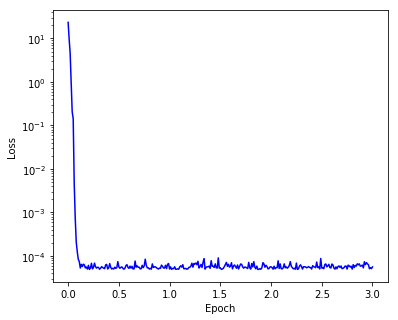

In [5]:
# 随机梯度下降
train(batch_size=1, lr=0.1, epochs=3, period=10)

Epoch 0, lr : 0, Train Loss 0.15286
W : [ 2.53748322 -3.25920725], b : 4.18508
Epoch 1, lr : 0, Train Loss 0.00143
W : [ 1.99469638 -3.36049438], b : 4.16367
Epoch 2, lr : 0, Train Loss 0.00006
W : [ 2.00522447 -3.39686561], b : 4.1986


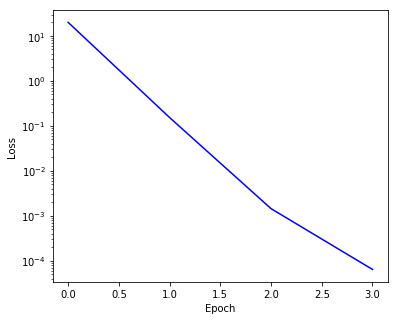

In [6]:
# 梯度下降
train(batch_size=1000, lr=0.999, epochs=3, period=1000)

Epoch 0, lr : 0, Train Loss 0.00005
W : [ 2.00080633 -3.40046406], b : 4.20079
Epoch 1, lr : 0, Train Loss 0.00005
W : [ 1.9999212  -3.39929795], b : 4.19979
Epoch 2, lr : 0, Train Loss 0.00005
W : [ 2.00159383 -3.39939809], b : 4.19956


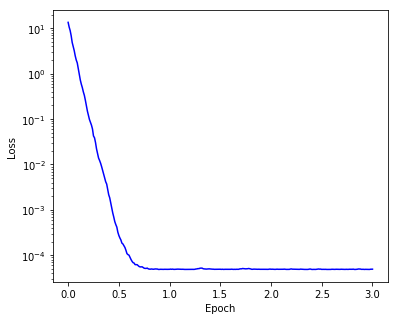

In [10]:
# mini-batch 随机梯度下降
train(batch_size=10, lr=0.1, epochs=3, period=10)

Epoch 0, lr : 5, Train Loss nan
W : [ nan  nan], b : nan
Epoch 1, lr : 5, Train Loss nan
W : [ nan  nan], b : nan
Epoch 2, lr : 5, Train Loss nan
W : [ nan  nan], b : nan


/home/liang/.virtualenvs/liang-jupyter/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


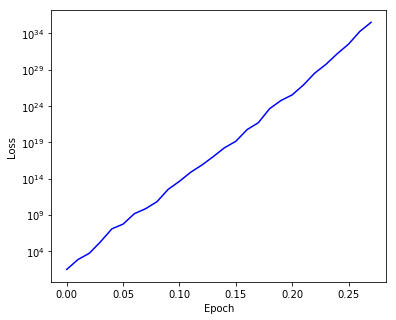

In [12]:
# 发散的情况
train(batch_size=10, lr=5, epochs=3, period=10)

#### 可以看到，小批量随机梯度下降的效果确实是最好的，我们在实际的使用中也是使用这种方法最多。